In [1]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.
import nest_asyncio
nest_asyncio.apply()

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *
from diffusion_curvature.sadspheres import *

%load_ext autoreload
%autoreload 2

# 2c1 Kernel Bandwidth and its effects on Curvature Detection
> 

Here we use the SadSpheres dataset to evaluate DC's differentiation between negative and positive curvature under different kernel conditions.

**Hypothesis**: Larger kernel bandwidths with no anisotropy will perform the best. Smaller bandwidths with anisotropy will perform second best.

In [2]:
import asyncio

import logging
logging.getLogger().setLevel(logging.ERROR)


def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

# Dimension 2

In [8]:
import asyncio
from tqdm import trange
dim = 2
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
)

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [0, 0.5, 1]:
        for k in [5, 10, 15, 25]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's: 100%|█| 100/100 [13:42<00:00,  8.23


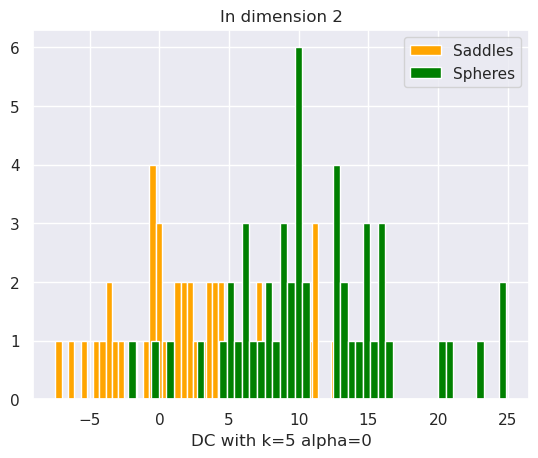

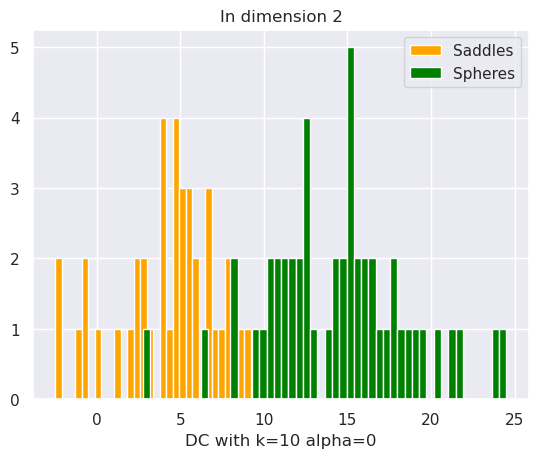

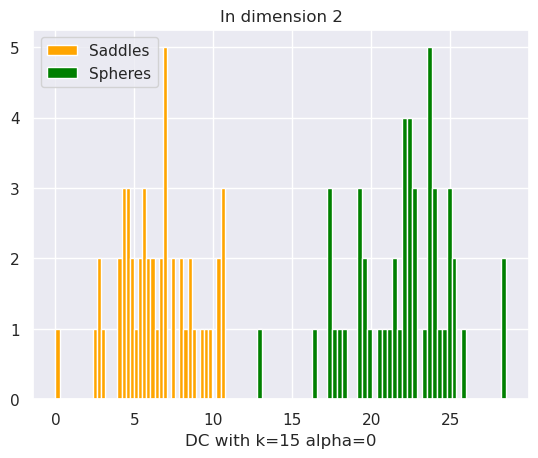

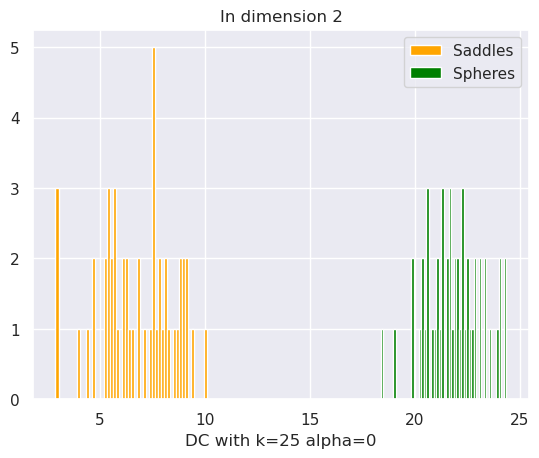

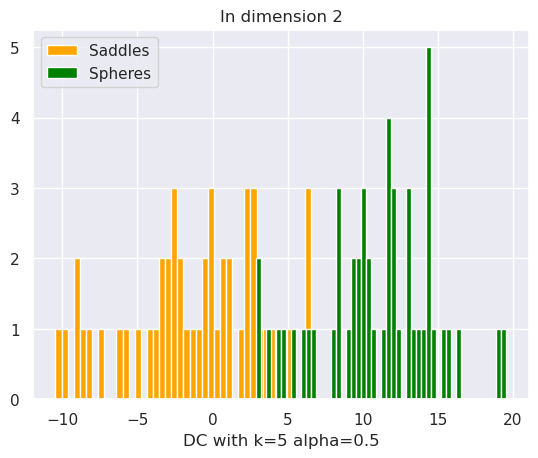

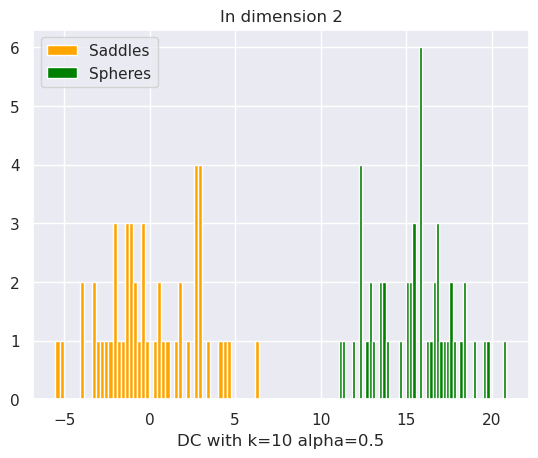

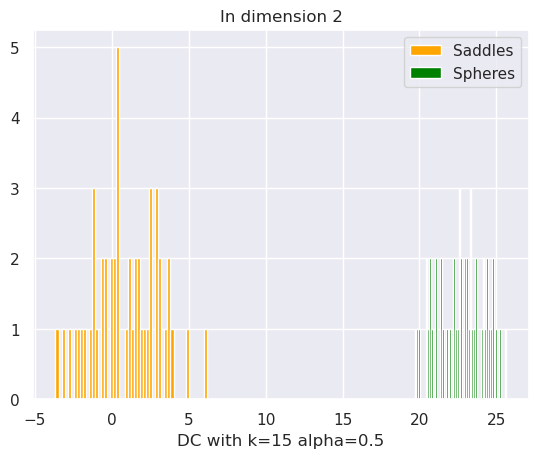

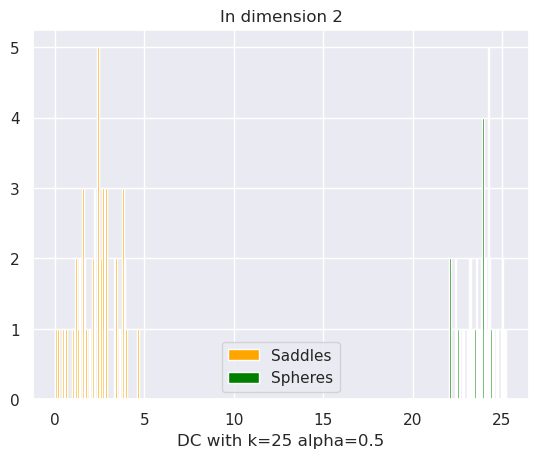

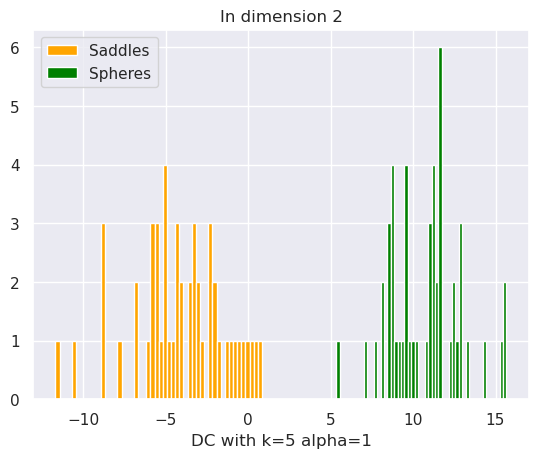

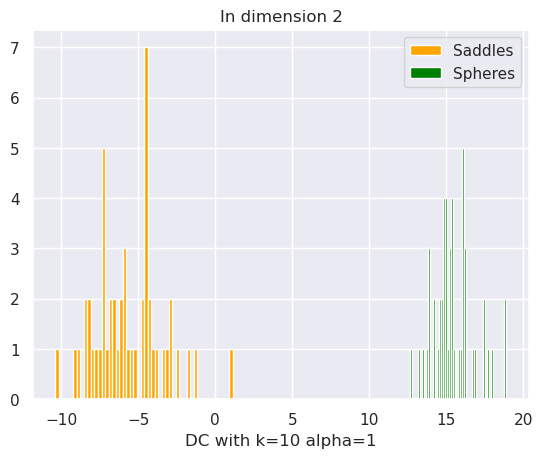

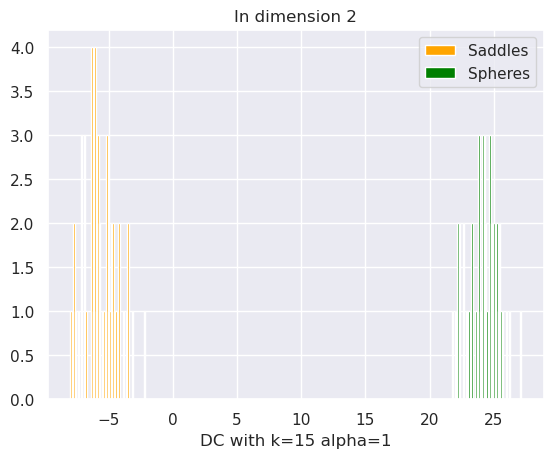

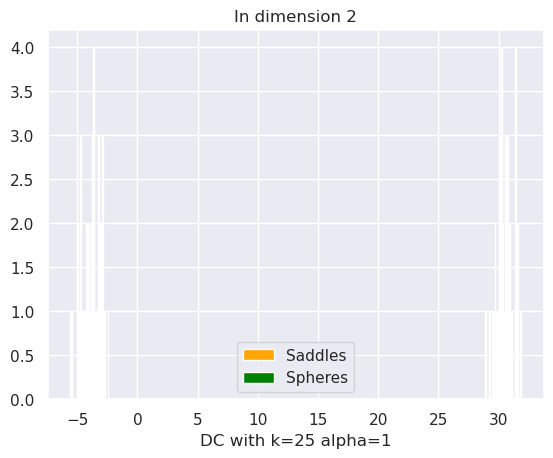

pearson_r  \
ks                                                        (1.0, 0.0)   
DC with k=5 alpha=0      (0.5689179837064169, 6.597272170612922e-10)   
DC with k=10 alpha=0    (0.7167914440086954, 5.0139390515993874e-17)   
DC with k=15 alpha=0    (0.9401179099426071, 1.3261615507845246e-47)   
DC with k=25 alpha=0      (0.979318070947348, 8.078584167190692e-70)   
DC with k=5 alpha=0.5      (0.8133855116574804, 8.6112837910675e-25)   
DC with k=10 alpha=0.5   (0.9517873480391862, 4.288561812721626e-52)   
DC with k=15 alpha=0.5   (0.985645148524783, 1.5903327630516467e-77)   
DC with k=25 alpha=0.5   (0.996061961759442, 6.083336271768762e-105)   
DC with k=5 alpha=1      (0.9488893486153358, 6.984827946263619e-51)   
DC with k=10 alpha=1     (0.9853815024784688, 3.855438690771767e-77)   
DC with k=15 alpha=1     (0.996381422793054, 9.706188636446322e-107)   
DC with k=25 alpha=1      (0.9991604980351612, 8.3980054677387e-138)   

                        sign_score  
ks                        0.693147  
DC with k=5 alpha=0       0.089721  
DC with k=10 alpha=0      0.035974  
DC with k=15 alpha=0      0.000000  
DC with k=25 alpha=0      0.000000  
DC with k=5 alpha=0.5     0.262006  
DC with k=10 alpha=0.5    0.249988  
DC with k=15 alpha=0.5    0.126235  
DC with k=25 alpha=0.5    0.000000  
DC with k=5 alpha=1       0.577862  
DC with k=10 alpha=1      0.643928  
DC with k=15 alpha=1      0.693147  
DC with k=25 alpha=1      0.693147

In [9]:
SS.plot()
SS.table()

# Dimension 3

In [11]:
import asyncio
from tqdm import trange
dim = 3
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
)

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [0, 0.5, 1]:
        for k in [5, 10, 15, 25]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())


Processing X's:   0%|      | 0/100 [00:00<?, ?it/s]
Processing X's:   1%| | 1/100 [00:07<12:54,  7.83s/
Processing X's:   2%| | 2/100 [00:15<12:49,  7.85s/
Processing X's:   3%| | 3/100 [00:23<12:40,  7.84s/
Processing X's:   4%| | 4/100 [00:31<12:29,  7.81s/
Processing X's:   5%| | 5/100 [00:39<12:22,  7.81s/
Processing X's:   6%| | 6/100 [00:46<12:14,  7.81s/
Processing X's:   7%| | 7/100 [00:54<12:11,  7.87s/
Processing X's:   8%| | 8/100 [01:02<12:05,  7.88s/
Processing X's:   9%| | 9/100 [01:10<11:56,  7.87s/
Processing X's:  10%| | 10/100 [01:18<11:51,  7.91s
Processing X's:  11%| | 11/100 [01:26<11:39,  7.85s
Processing X's:  12%| | 12/100 [01:34<11:31,  7.86s
Processing X's:  13%|▏| 13/100 [01:42<11:25,  7.88s
Processing X's:  14%|▏| 14/100 [01:49<11:14,  7.84s
Processing X's:  15%|▏| 15/100 [01:57<11:11,  7.90s
Processing X's:  16%|▏| 16/100 [02:05<11:01,  7.87s
Processing X's:  17%|▏| 17/100 [02:13<10:52,  7.86s
Processing X's:  18%|▏| 18/100 [02:21<10:46,  7.88s
Processing 

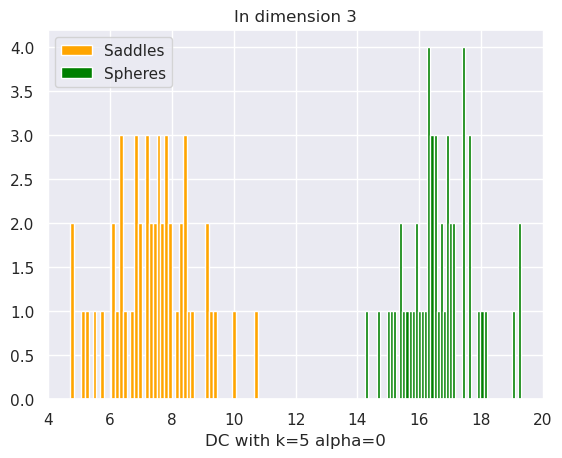

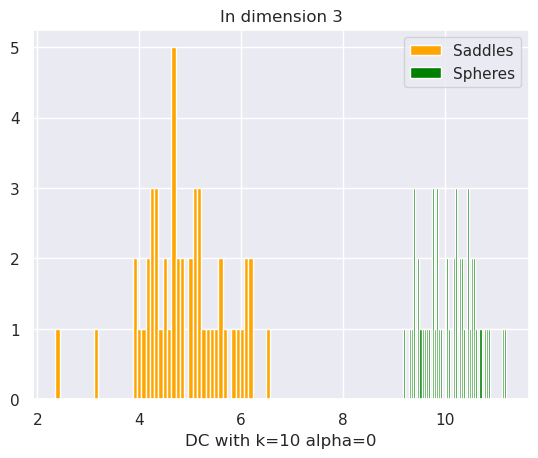

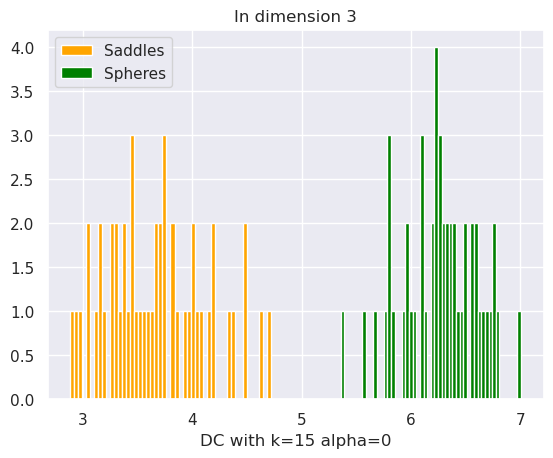

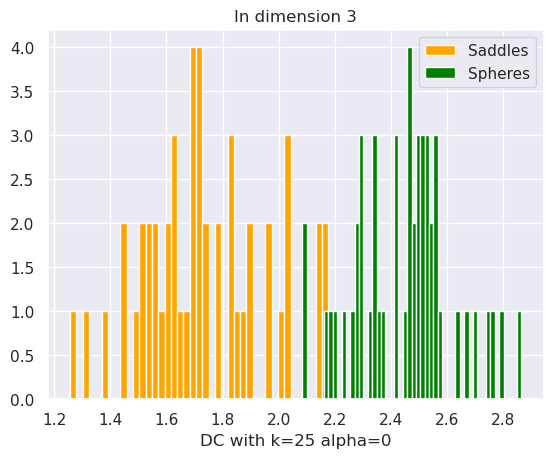

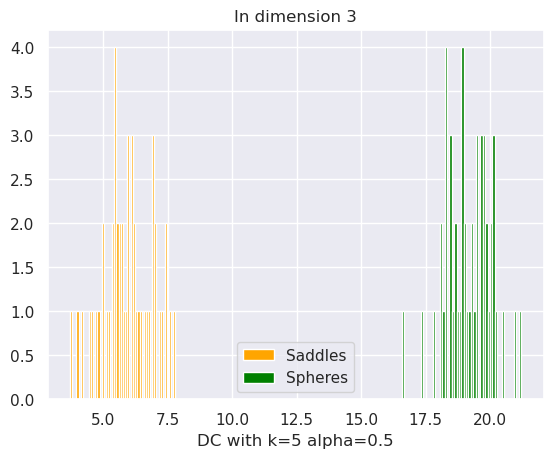

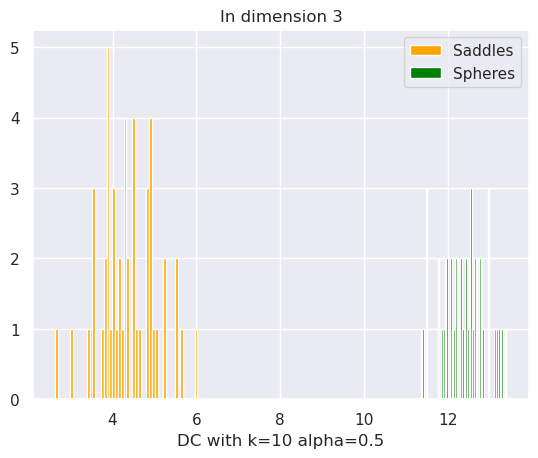

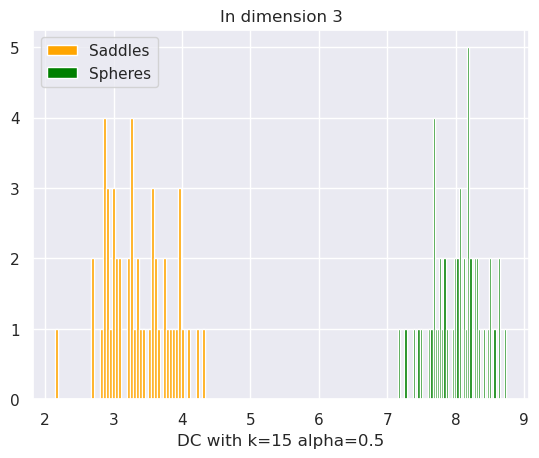

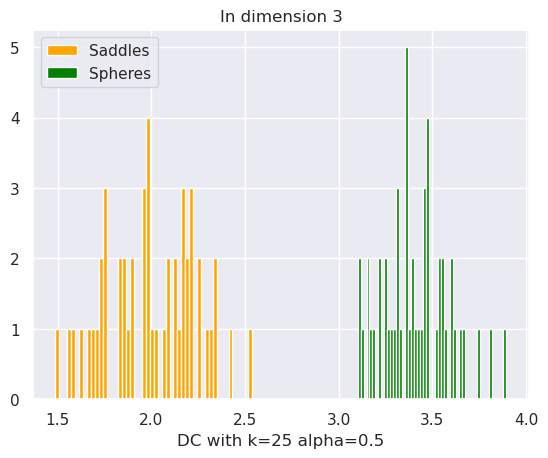

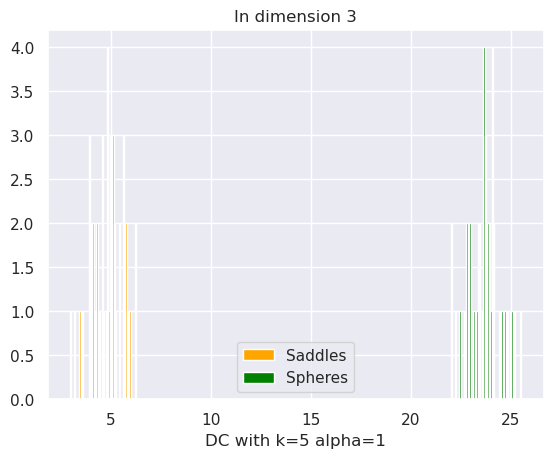

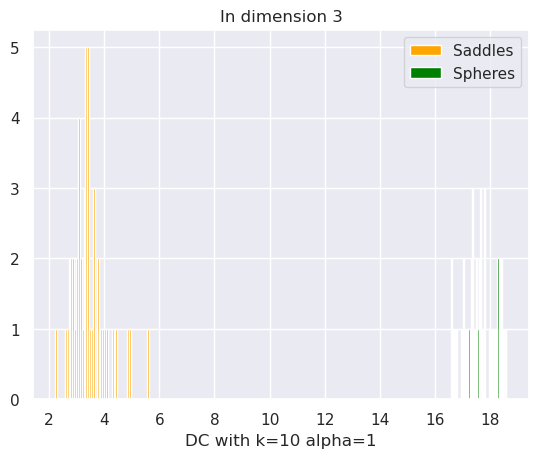

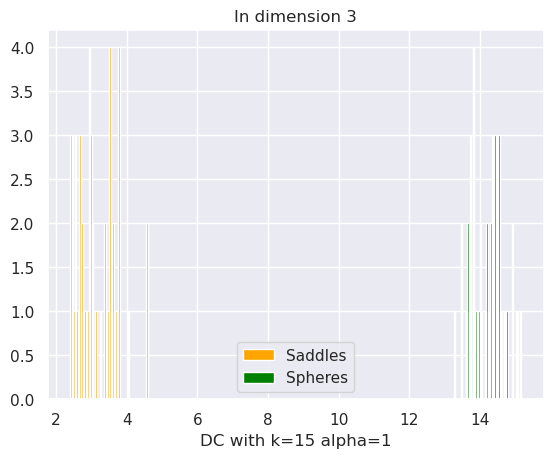

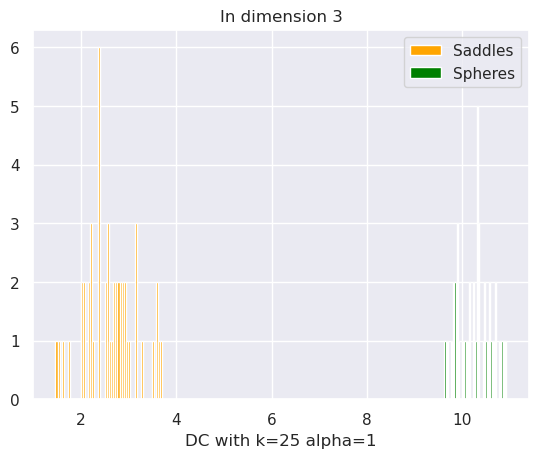

pearson_r  \
ks                                                         (1.0, 0.0)   
DC with k=5 alpha=0        (0.968597285385254, 4.829140389694893e-61)   
DC with k=10 alpha=0      (0.9686844431707415, 4.223068138696091e-61)   
DC with k=15 alpha=0      (0.9548961711231331, 1.763446372264126e-53)   
DC with k=25 alpha=0     (0.8620660216560584, 1.1011352680264362e-30)   
DC with k=5 alpha=0.5     (0.9904506000411617, 3.773541033730877e-86)   
DC with k=10 alpha=0.5    (0.9891438967659344, 1.961245726927143e-83)   
DC with k=15 alpha=0.5    (0.9845325706924772, 6.006117270847887e-76)   
DC with k=25 alpha=0.5    (0.9577763462438575, 7.450580031077804e-55)   
DC with k=5 alpha=1       (0.9965604518443639, 8.11137614677842e-108)   
DC with k=10 alpha=1    (0.9964916565154935, 2.1371034533159722e-107)   
DC with k=15 alpha=1     (0.9958856633529359, 5.179792557443282e-104)   
DC with k=25 alpha=1     (0.9932588327858324, 1.5658084928376563e-93)   

                        sign_score  
ks                        0.693147  
DC with k=5 alpha=0       0.000000  
DC with k=10 alpha=0      0.000000  
DC with k=15 alpha=0      0.000000  
DC with k=25 alpha=0      0.000000  
DC with k=5 alpha=0.5     0.000000  
DC with k=10 alpha=0.5    0.000000  
DC with k=15 alpha=0.5    0.000000  
DC with k=25 alpha=0.5    0.000000  
DC with k=5 alpha=1       0.000000  
DC with k=10 alpha=1      0.000000  
DC with k=15 alpha=1      0.000000  
DC with k=25 alpha=1      0.000000

In [12]:
SS.plot()
SS.table()

# Dimension 4

In [16]:
import asyncio
from tqdm import trange
dim = 4
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
)

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [0, 0.5, 1]:
        for k in [5, 10, 15, 25]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())


Processing X's:   0%|      | 0/100 [00:00<?, ?it/s]
Processing X's:   1%| | 1/100 [00:08<14:26,  8.75s/
Processing X's:   2%| | 2/100 [00:17<14:13,  8.71s/
Processing X's:   3%| | 3/100 [00:25<13:52,  8.59s/
Processing X's:   4%| | 4/100 [00:34<13:31,  8.46s/
Processing X's:   5%| | 5/100 [00:42<13:22,  8.45s/
Processing X's:   6%| | 6/100 [00:50<13:07,  8.37s/
Processing X's:   7%| | 7/100 [00:59<13:06,  8.46s/
Processing X's:   8%| | 8/100 [01:07<12:53,  8.41s/
Processing X's:   9%| | 9/100 [01:16<12:42,  8.37s/
Processing X's:  10%| | 10/100 [01:24<12:38,  8.43s
Processing X's:  11%| | 11/100 [01:32<12:25,  8.38s
Processing X's:  12%| | 12/100 [01:41<12:14,  8.34s
Processing X's:  13%|▏| 13/100 [01:49<12:08,  8.38s
Processing X's:  14%|▏| 14/100 [01:57<11:55,  8.32s
Processing X's:  15%|▏| 15/100 [02:06<11:47,  8.32s
Processing X's:  16%|▏| 16/100 [02:14<11:44,  8.38s
Processing X's:  17%|▏| 17/100 [02:22<11:32,  8.34s
Processing X's:  18%|▏| 18/100 [02:31<11:27,  8.39s
Processing 

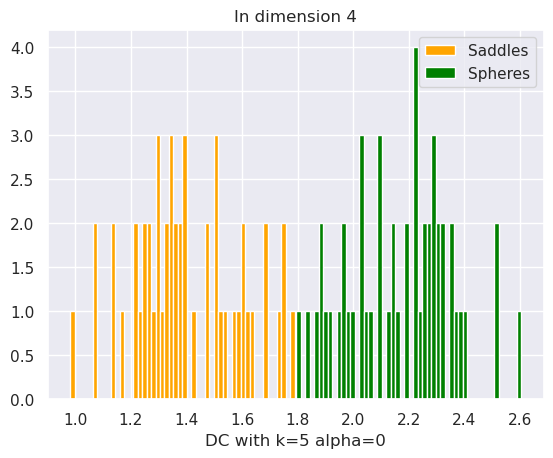

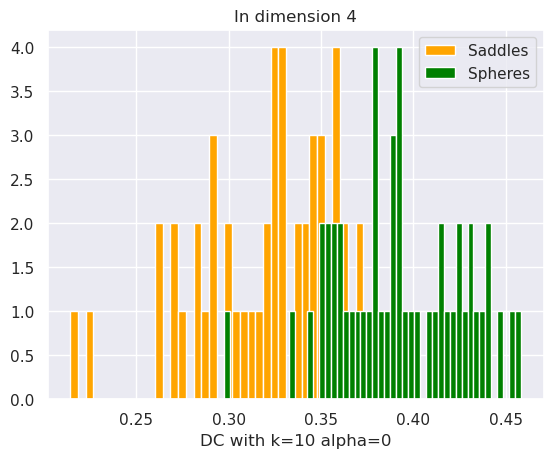

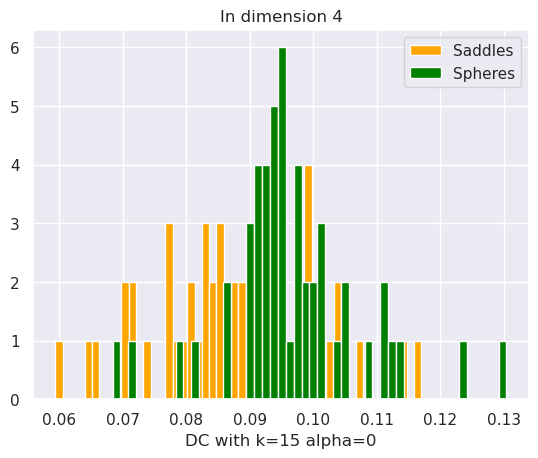

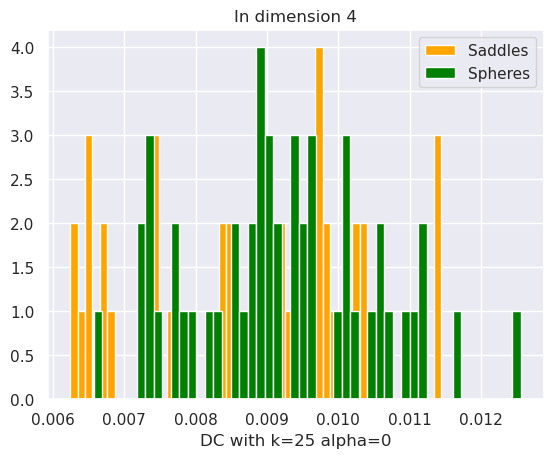

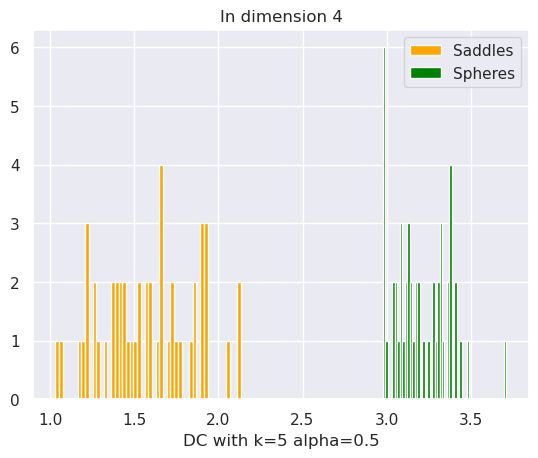

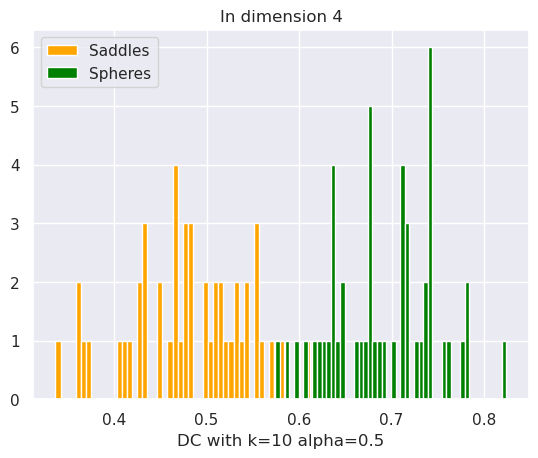

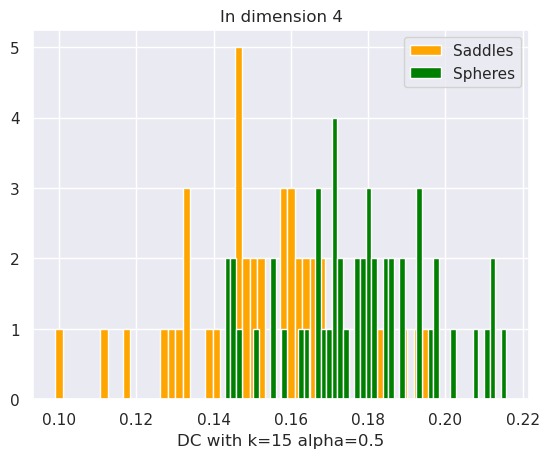

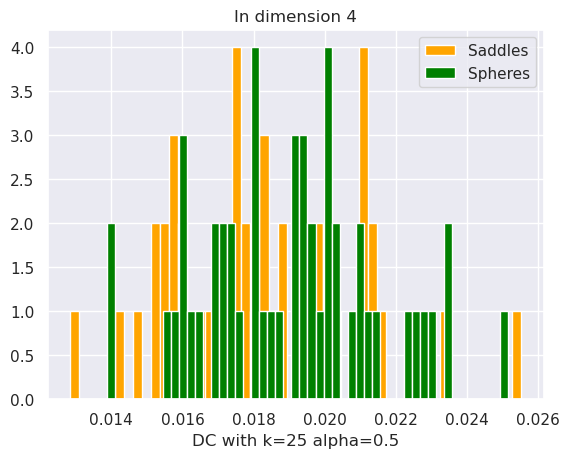

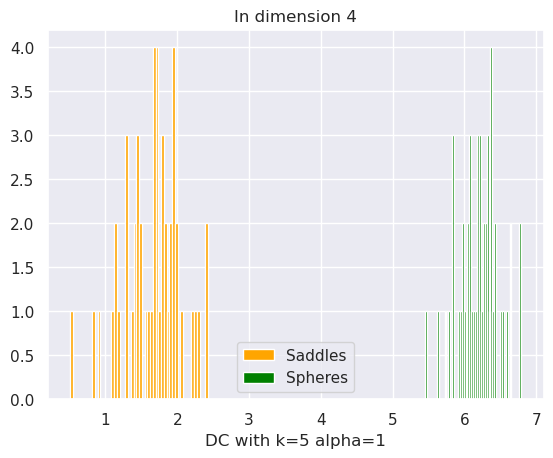

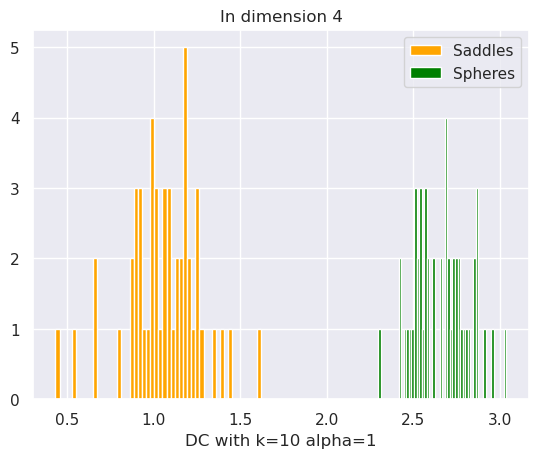

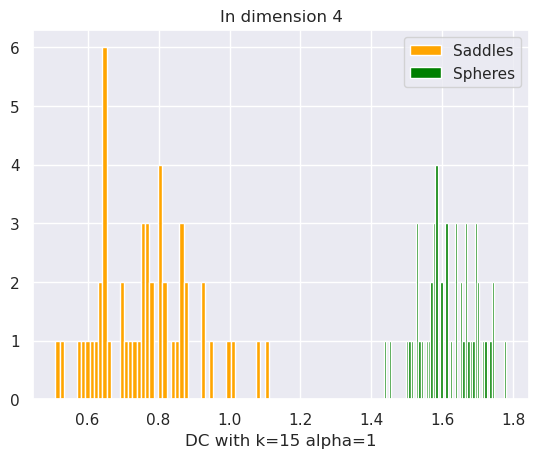

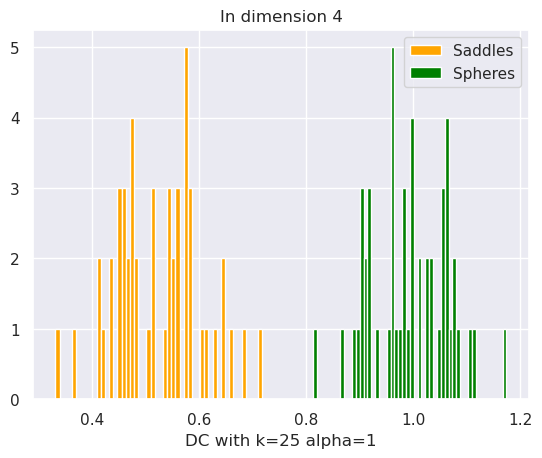

pearson_r  \
ks                                                        (1.0, 0.0)   
DC with k=5 alpha=0      (0.8957613648562889, 2.797502229862004e-36)   
DC with k=10 alpha=0    (0.6812362734982675, 6.2061906721045545e-15)   
DC with k=15 alpha=0    (0.35484702812355395, 0.0002917850907210785)   
DC with k=25 alpha=0      (0.15994066292962197, 0.11193647662978223)   
DC with k=5 alpha=0.5   (0.9642440186314379, 2.5198093186451995e-58)   
DC with k=10 alpha=0.5   (0.8631281687250504, 7.743783160547967e-31)   
DC with k=15 alpha=0.5  (0.5001945881383133, 1.1651529163936669e-07)   
DC with k=25 alpha=0.5     (0.12886571612674896, 0.2013232335082501)   
DC with k=5 alpha=1      (0.9890197964233575, 3.413049922021505e-83)   
DC with k=10 alpha=1     (0.9737624861210966, 8.188234070691542e-65)   
DC with k=15 alpha=1      (0.9686803807922949, 4.24958345028858e-61)   
DC with k=25 alpha=1    (0.9508137284319701, 1.1158082328380714e-51)   

                        sign_score  
ks                        0.693147  
DC with k=5 alpha=0       0.000000  
DC with k=10 alpha=0      0.000000  
DC with k=15 alpha=0      0.000000  
DC with k=25 alpha=0      0.000000  
DC with k=5 alpha=0.5     0.000000  
DC with k=10 alpha=0.5    0.000000  
DC with k=15 alpha=0.5    0.000000  
DC with k=25 alpha=0.5    0.000000  
DC with k=5 alpha=1       0.000000  
DC with k=10 alpha=1      0.000000  
DC with k=15 alpha=1      0.000000  
DC with k=25 alpha=1      0.000000

In [17]:
SS.plot()
SS.table()

# Dimension 2 - Entropic

# Dimension 3 - Entropic

In [21]:
import asyncio
from tqdm import trange
dim = 3
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
)

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Entropic",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [0, 0.5, 1]:
        for k in [5, 10, 15, 25]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())


Processing X's:   0%|      | 0/100 [00:00<?, ?it/s]
Processing X's:   1%| | 1/100 [00:05<08:53,  5.39s/
Processing X's:   2%| | 2/100 [00:10<08:11,  5.01s/
Processing X's:   3%| | 3/100 [00:14<07:51,  4.86s/
Processing X's:   4%| | 4/100 [00:19<07:45,  4.85s/
Processing X's:   5%| | 5/100 [00:24<07:51,  4.97s/
Processing X's:   6%| | 6/100 [00:29<07:43,  4.94s/
Processing X's:   7%| | 7/100 [00:34<07:25,  4.79s/
Processing X's:   8%| | 8/100 [00:38<07:16,  4.74s/
Processing X's:   9%| | 9/100 [00:43<07:06,  4.69s/
Processing X's:  10%| | 10/100 [00:47<06:58,  4.65s
Processing X's:  11%| | 11/100 [00:52<06:50,  4.61s
Processing X's:  12%| | 12/100 [00:56<06:43,  4.58s
Processing X's:  13%|▏| 13/100 [01:01<06:35,  4.55s
Processing X's:  14%|▏| 14/100 [01:05<06:30,  4.54s
Processing X's:  15%|▏| 15/100 [01:10<06:23,  4.52s
Processing X's:  16%|▏| 16/100 [01:14<06:19,  4.52s
Processing X's:  17%|▏| 17/100 [01:19<06:15,  4.53s
Processing X's:  18%|▏| 18/100 [01:24<06:11,  4.53s
Processing 

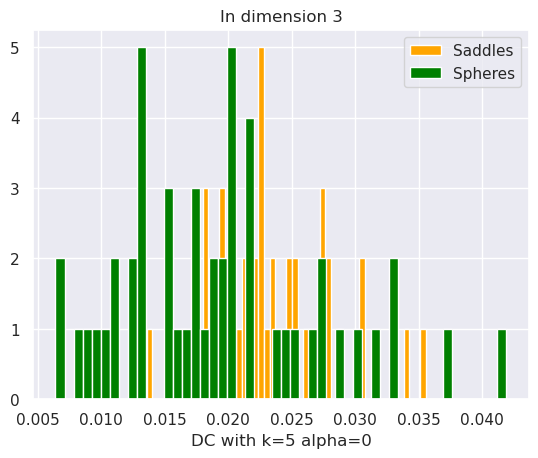

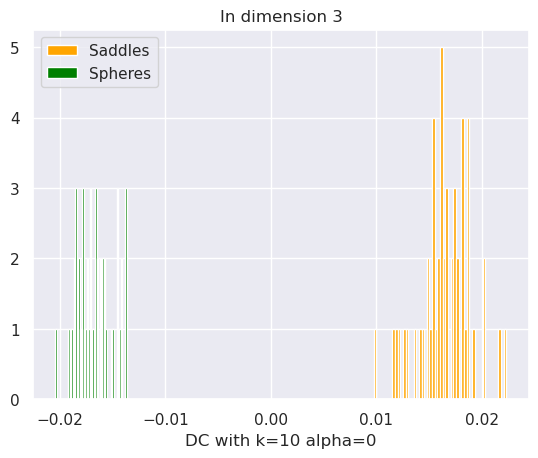

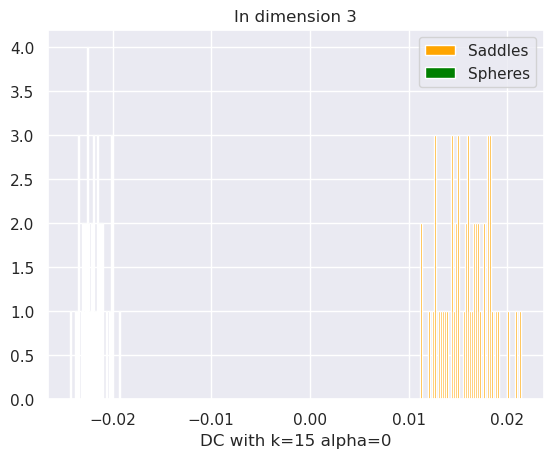

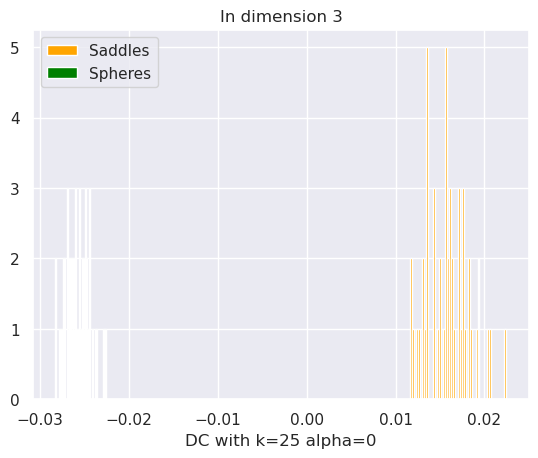

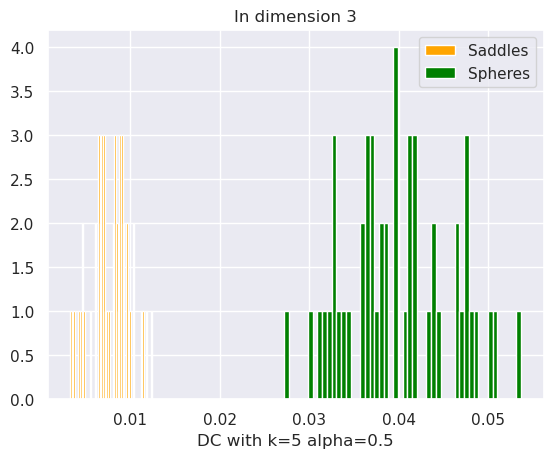

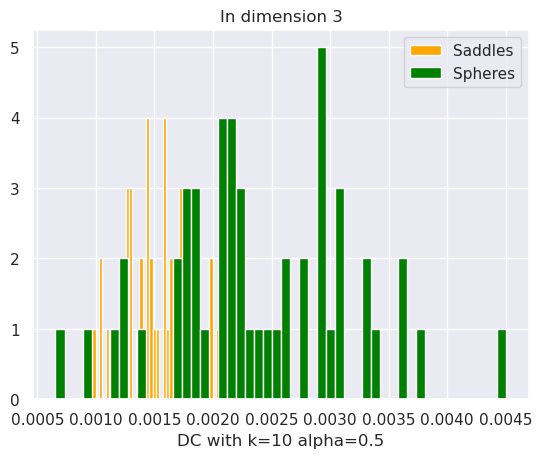

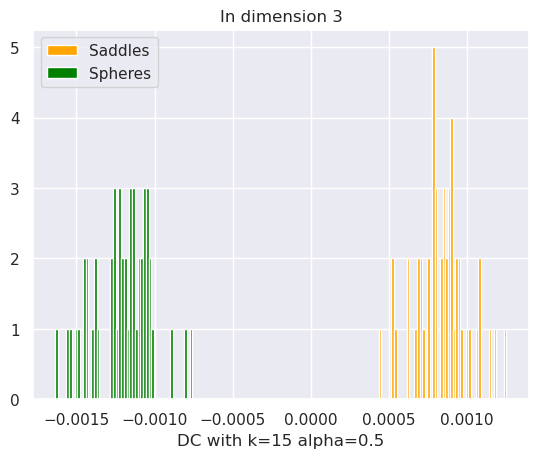

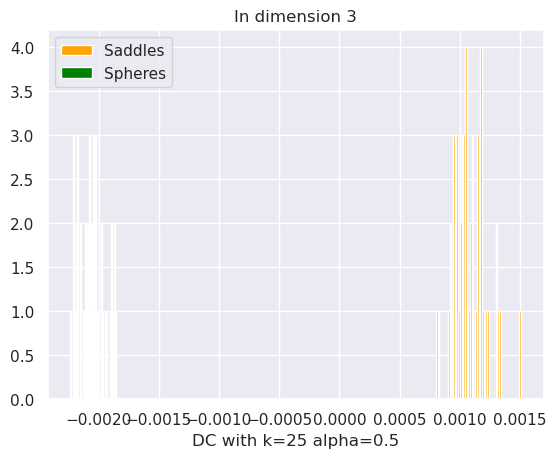

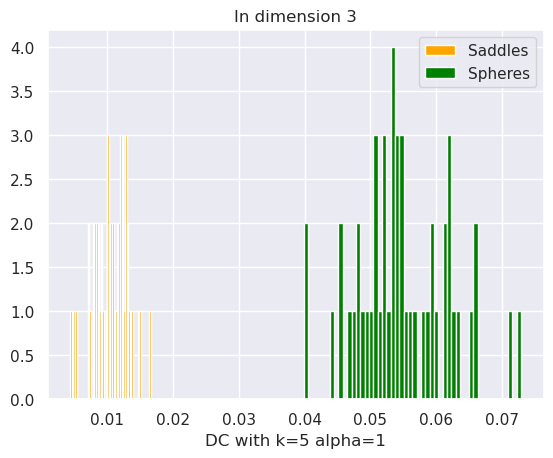

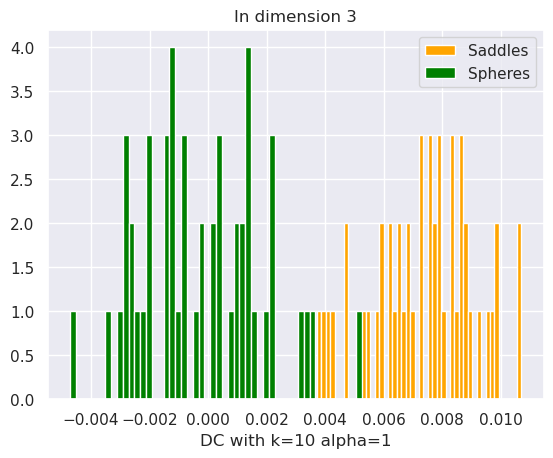

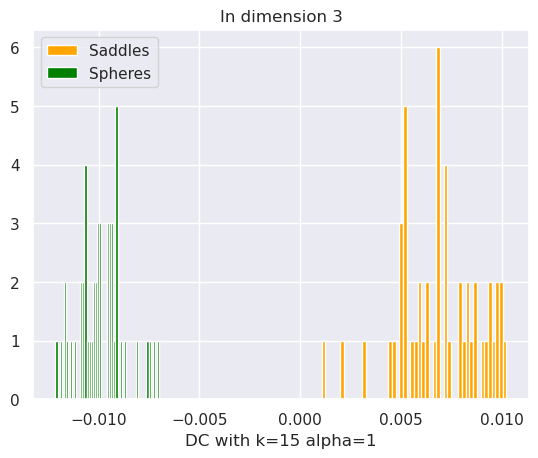

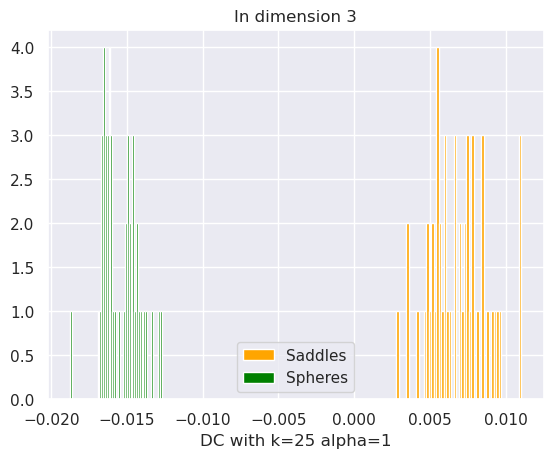

pearson_r  \
ks                                                          (1.0, 0.0)   
DC with k=5 alpha=0      (-0.31780853971896394, 0.0012725676891209743)   
DC with k=10 alpha=0     (-0.9920378433186096, 5.3052742997091625e-90)   
DC with k=15 alpha=0     (-0.9952852707579842, 4.044420175888577e-101)   
DC with k=25 alpha=0     (-0.9955986982630323, 1.400102263846175e-102)   
DC with k=5 alpha=0.5      (0.9634004517940902, 7.741455644645551e-58)   
DC with k=10 alpha=0.5      (0.5919507710522444, 8.80411922148223e-11)   
DC with k=15 alpha=0.5   (-0.9855026540779825, 2.5717126425496936e-77)   
DC with k=25 alpha=0.5  (-0.9971356911599135, 1.0480531564887322e-111)   
DC with k=5 alpha=1         (0.972153231036104, 1.456432301108259e-63)   
DC with k=10 alpha=1      (-0.8891419912545604, 4.849053566770334e-35)   
DC with k=15 alpha=1     (-0.9810520459598697, 1.1529489504113305e-71)   
DC with k=25 alpha=1     (-0.9901537051166859, 1.6797443736383317e-85)   

                        sign_score  
ks                        0.693147  
DC with k=5 alpha=0       0.000000  
DC with k=10 alpha=0      0.693147  
DC with k=15 alpha=0      0.693147  
DC with k=25 alpha=0      0.693147  
DC with k=5 alpha=0.5     0.000000  
DC with k=10 alpha=0.5    0.000000  
DC with k=15 alpha=0.5    0.693147  
DC with k=25 alpha=0.5    0.693147  
DC with k=5 alpha=1       0.000000  
DC with k=10 alpha=1      0.238287  
DC with k=15 alpha=1      0.693147  
DC with k=25 alpha=1      0.693147

In [22]:
SS.plot()
SS.table()

In [18]:
import asyncio
from tqdm import trange
dim = 2
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
)

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Entropic",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [0, 0.5, 1]:
        for k in [5, 10, 15, 25]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())


Processing X's:   0%|      | 0/100 [00:00<?, ?it/s]
Processing X's:   1%| | 1/100 [00:04<08:09,  4.94s/
Processing X's:   2%| | 2/100 [00:09<07:53,  4.83s/
Processing X's:   3%| | 3/100 [00:14<07:29,  4.64s/
Processing X's:   4%| | 4/100 [00:18<07:25,  4.64s/
Processing X's:   5%| | 5/100 [00:23<07:14,  4.58s/
Processing X's:   6%| | 6/100 [00:27<07:09,  4.57s/
Processing X's:   7%| | 7/100 [00:32<07:09,  4.62s/
Processing X's:   8%| | 8/100 [00:36<07:00,  4.57s/
Processing X's:   9%| | 9/100 [00:41<06:53,  4.54s/
Processing X's:  10%| | 10/100 [00:45<06:48,  4.54s
Processing X's:  11%| | 11/100 [00:50<06:43,  4.54s
Processing X's:  12%| | 12/100 [00:55<06:38,  4.53s
Processing X's:  13%|▏| 13/100 [00:59<06:34,  4.54s
Processing X's:  14%|▏| 14/100 [01:04<06:30,  4.54s
Processing X's:  15%|▏| 15/100 [01:08<06:24,  4.53s
Processing X's:  16%|▏| 16/100 [01:13<06:21,  4.54s
Processing X's:  17%|▏| 17/100 [01:17<06:14,  4.52s
Processing X's:  18%|▏| 18/100 [01:22<06:10,  4.52s
Processing 

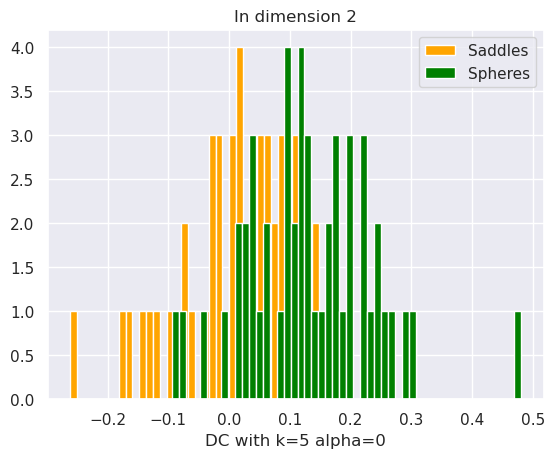

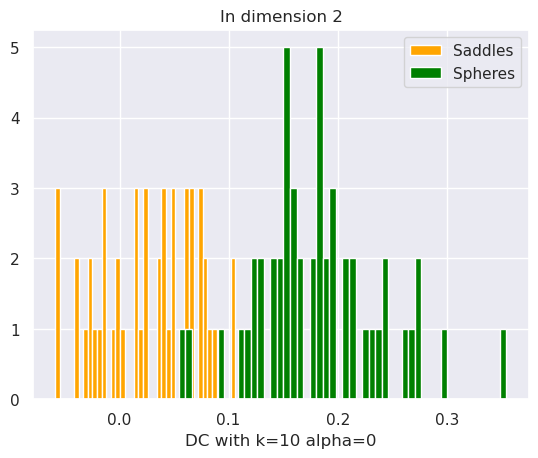

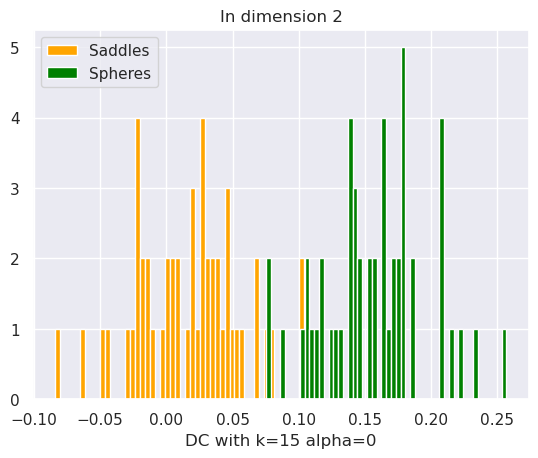

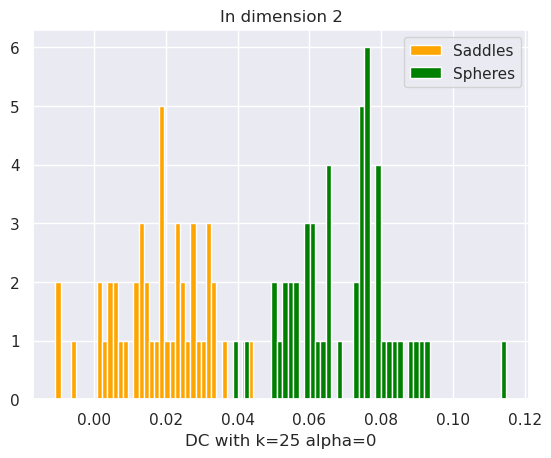

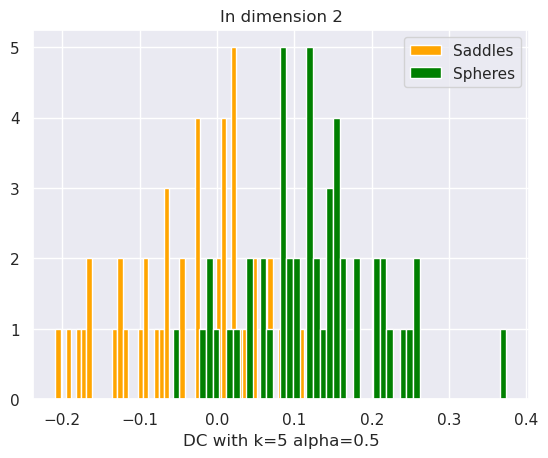

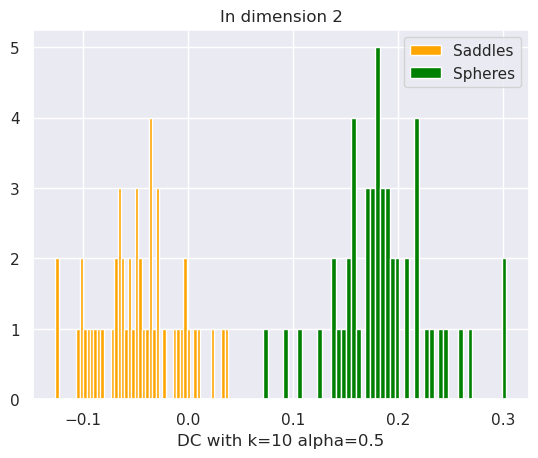

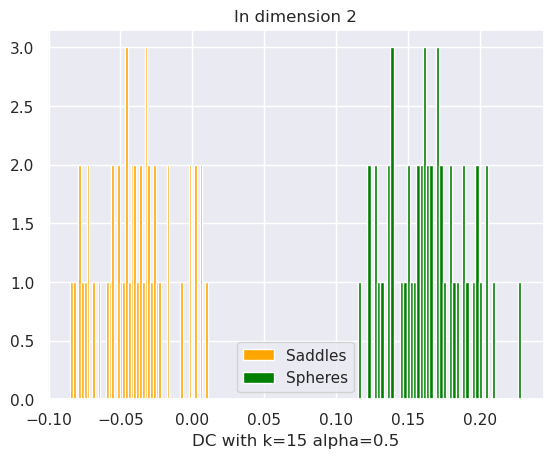

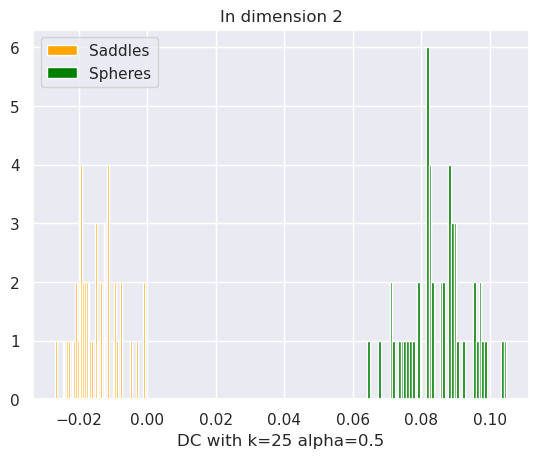

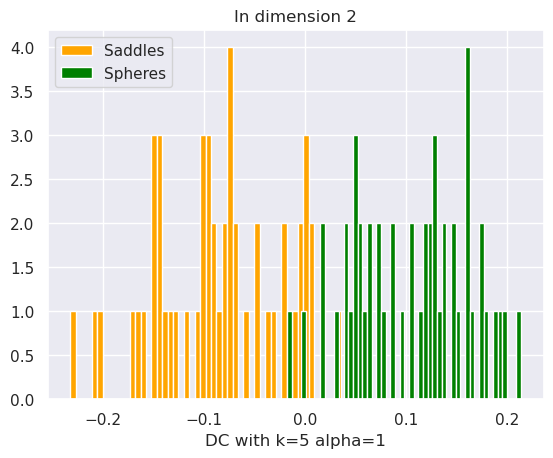

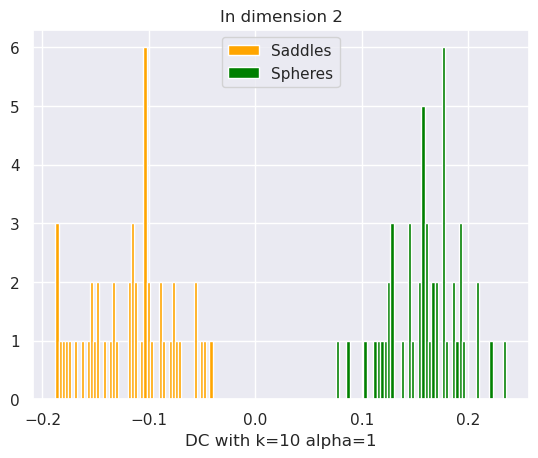

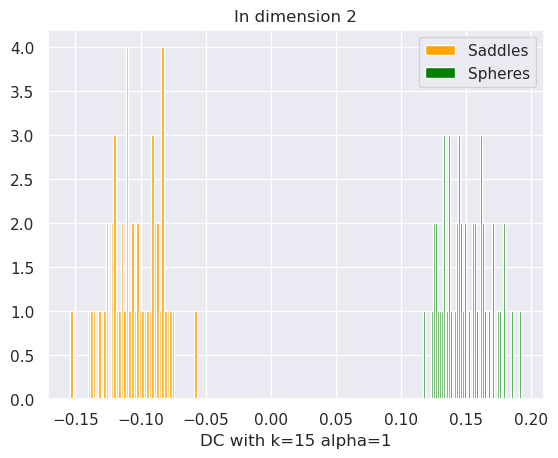

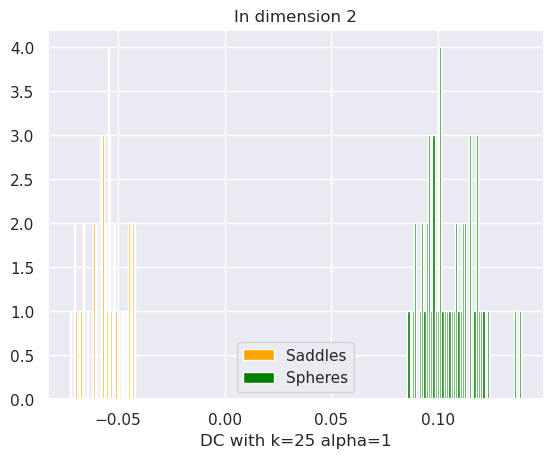

pearson_r  \
ks                                                         (1.0, 0.0)   
DC with k=5 alpha=0     (0.48466992631363615, 3.2259977386136396e-07)   
DC with k=10 alpha=0     (0.8183963662374555, 2.5821457250347335e-25)   
DC with k=15 alpha=0     (0.8732208021578757, 2.3386444840918238e-32)   
DC with k=25 alpha=0     (0.8536927668837876, 1.6002575748286458e-29)   
DC with k=5 alpha=0.5     (0.668943589183278, 2.8148783087509274e-14)   
DC with k=10 alpha=0.5    (0.9410436008248493, 6.321145403027702e-48)   
DC with k=15 alpha=0.5   (0.9703655564538223, 2.9434080927948186e-62)   
DC with k=25 alpha=0.5     (0.989030923643886, 3.248483087677036e-83)   
DC with k=5 alpha=1       (0.8514903449267005, 3.147301046790703e-29)   
DC with k=10 alpha=1       (0.9672864799369029, 3.47148411782153e-60)   
DC with k=15 alpha=1     (0.9892315513794374, 1.3210268857140955e-83)   
DC with k=25 alpha=1      (0.9924462948954049, 4.057248924725425e-91)   

                        sign_score  
ks                        0.693147  
DC with k=5 alpha=0       0.067860  
DC with k=10 alpha=0      0.126235  
DC with k=15 alpha=0      0.126235  
DC with k=25 alpha=0      0.021258  
DC with k=5 alpha=0.5     0.110386  
DC with k=10 alpha=0.5    0.525597  
DC with k=15 alpha=0.5    0.525597  
DC with k=25 alpha=0.5    0.693147  
DC with k=5 alpha=1       0.422509  
DC with k=10 alpha=1      0.693147  
DC with k=15 alpha=1      0.693147  
DC with k=25 alpha=1      0.693147

In [20]:
SS.plot()
SS.table()

# Dimension 4 - Entropic

In [15]:
import asyncio
from tqdm import trange
dim = 4
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
)

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Entropic",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [0, 0.5, 1]:
        for k in [5, 10, 15, 25]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())


Processing X's:   0%|      | 0/100 [00:00<?, ?it/s]
Processing X's:   1%| | 1/100 [00:05<08:37,  5.23s/
Processing X's:   2%| | 2/100 [00:09<07:50,  4.80s/
Processing X's:   3%| | 3/100 [00:14<07:31,  4.66s/
Processing X's:   4%| | 4/100 [00:18<07:22,  4.61s/
Processing X's:   5%| | 5/100 [00:23<07:10,  4.53s/
Processing X's:   6%| | 6/100 [00:27<07:05,  4.53s/
Processing X's:   7%| | 7/100 [00:32<07:00,  4.52s/
Processing X's:   8%| | 8/100 [00:36<06:55,  4.52s/
Processing X's:   9%| | 9/100 [00:41<06:48,  4.49s/
Processing X's:  10%| | 10/100 [00:45<06:44,  4.49s
Processing X's:  11%| | 11/100 [00:50<06:39,  4.49s
Processing X's:  12%| | 12/100 [00:54<06:38,  4.53s
Processing X's:  13%|▏| 13/100 [00:59<06:31,  4.49s
Processing X's:  14%|▏| 14/100 [01:03<06:27,  4.51s
Processing X's:  15%|▏| 15/100 [01:08<06:23,  4.51s
Processing X's:  16%|▏| 16/100 [01:12<06:18,  4.50s
Processing X's:  17%|▏| 17/100 [01:17<06:13,  4.50s
Processing X's:  18%|▏| 18/100 [01:21<06:09,  4.50s
Processing 

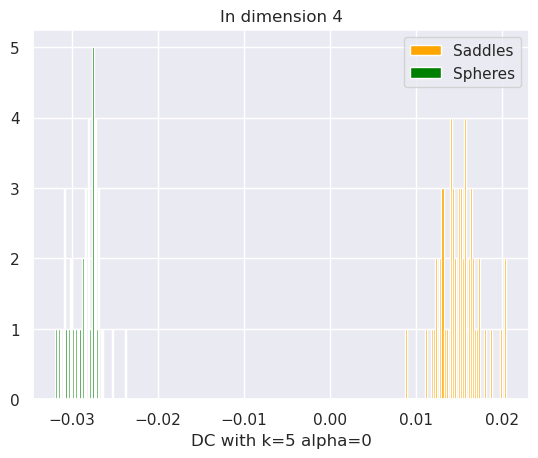

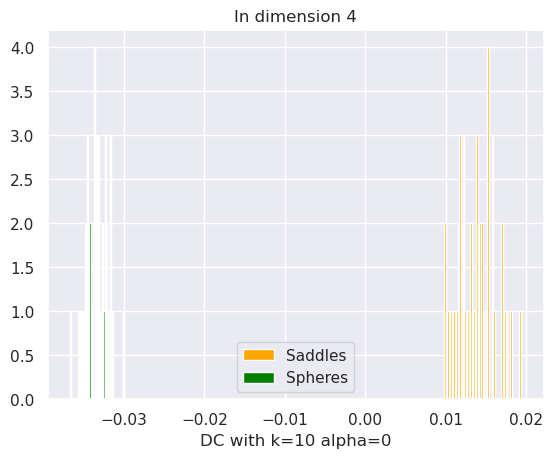

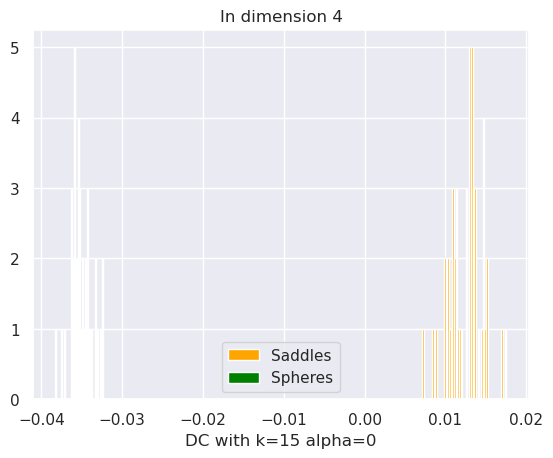

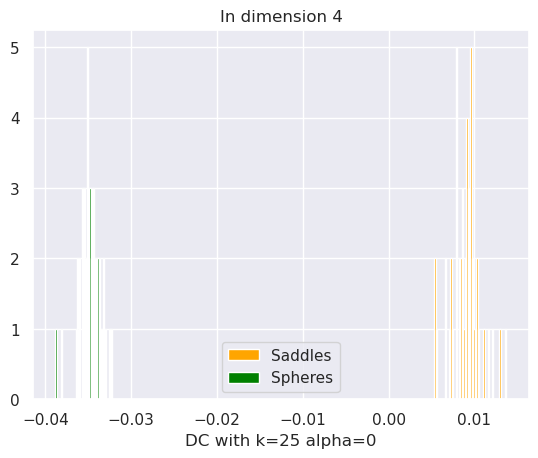

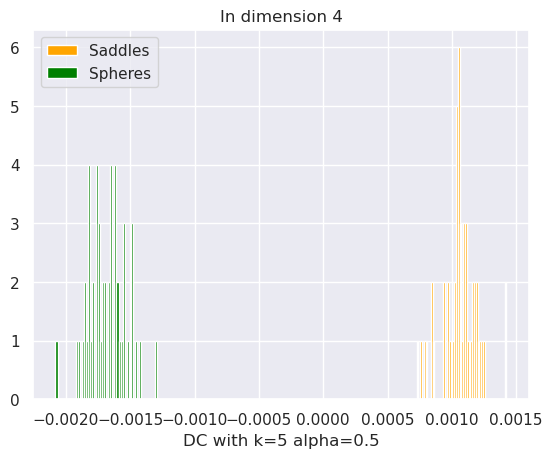

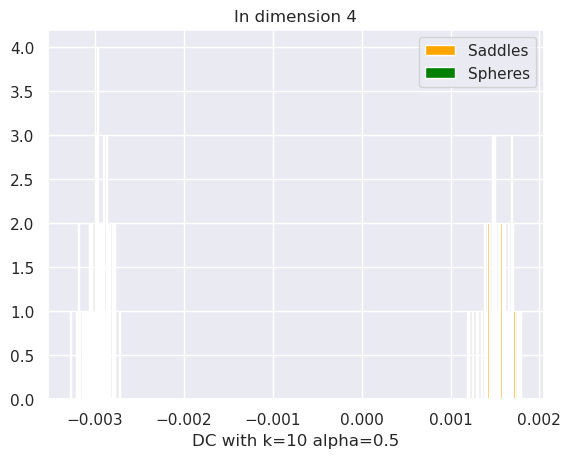

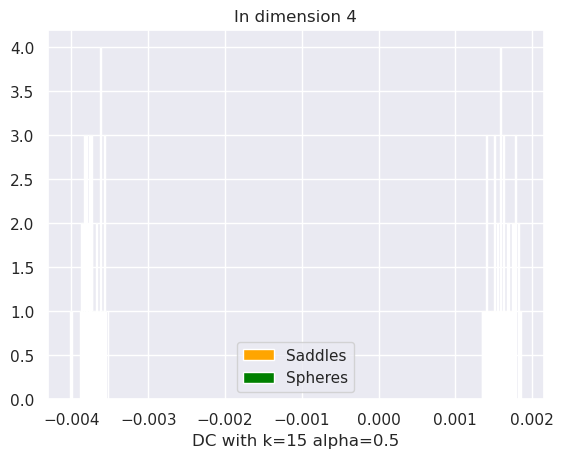

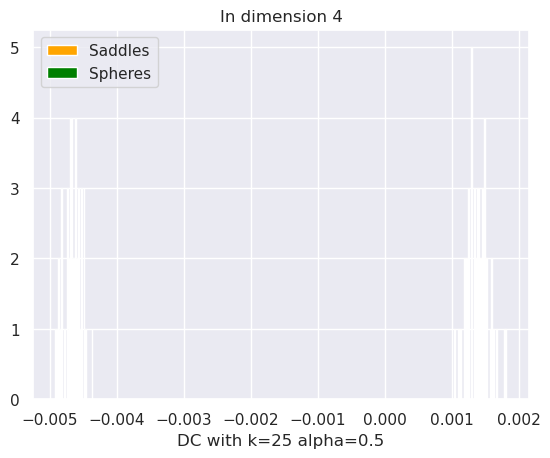

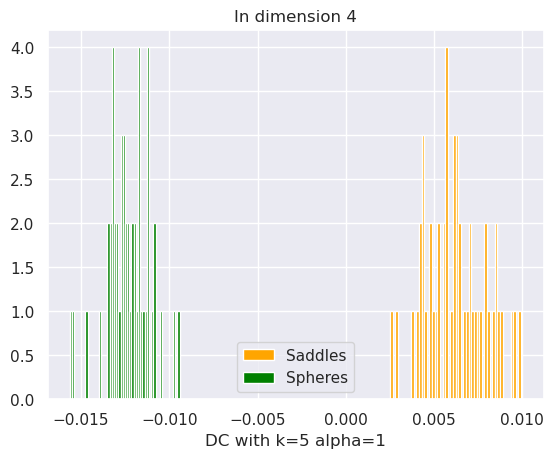

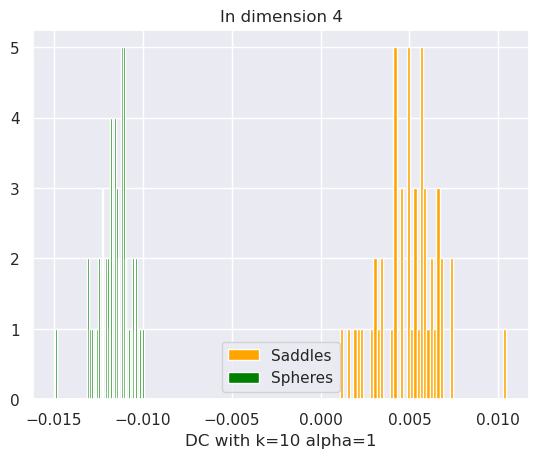

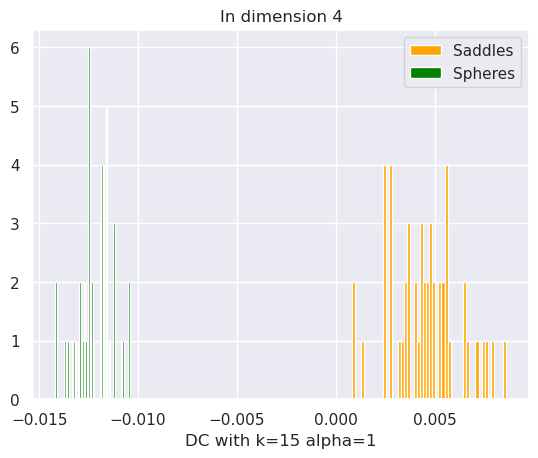

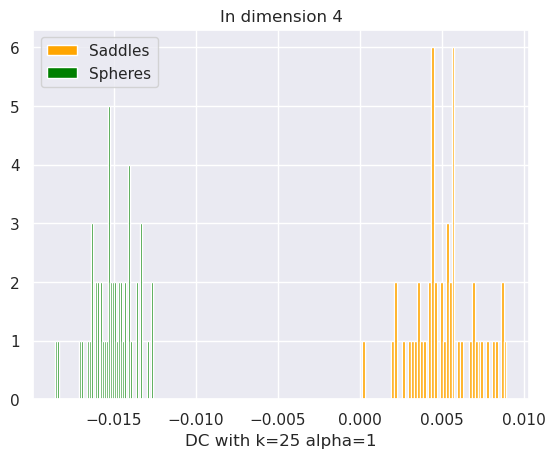

pearson_r  \
ks                                                          (1.0, 0.0)   
DC with k=5 alpha=0     (-0.9957757315555278, 1.8807010410495546e-103)   
DC with k=10 alpha=0     (-0.9970326041323351, 5.912285598498676e-111)   
DC with k=15 alpha=0    (-0.9974925731730228, 1.5568481106508854e-114)   
DC with k=25 alpha=0     (-0.9977511577673968, 7.563031565679202e-117)   
DC with k=5 alpha=0.5    (-0.9945706554291013, 4.0066430382761305e-98)   
DC with k=10 alpha=0.5   (-0.9982516438473797, 3.362699507563693e-122)   
DC with k=15 alpha=0.5    (-0.9988893431060716, 7.54669675300625e-132)   
DC with k=25 alpha=0.5   (-0.9988961577753719, 5.582821852446116e-132)   
DC with k=5 alpha=1      (-0.9874359232068094, 2.4230436634961662e-80)   
DC with k=10 alpha=1      (-0.986864538494281, 2.1130580850743803e-79)   
DC with k=15 alpha=1     (-0.9867140132687867, 3.6799294445778595e-79)   
DC with k=25 alpha=1     (-0.9876191680088804, 1.1846429018997595e-80)   

                        sign_score  
ks                        0.693147  
DC with k=5 alpha=0       0.693147  
DC with k=10 alpha=0      0.693147  
DC with k=15 alpha=0      0.693147  
DC with k=25 alpha=0      0.693147  
DC with k=5 alpha=0.5     0.693147  
DC with k=10 alpha=0.5    0.693147  
DC with k=15 alpha=0.5    0.693147  
DC with k=25 alpha=0.5    0.693147  
DC with k=5 alpha=1       0.693147  
DC with k=10 alpha=1      0.693147  
DC with k=15 alpha=1      0.693147  
DC with k=25 alpha=1      0.693147

In [16]:
SS.plot()
SS.table()

# Dimension 10 - Entropic 

In [17]:
import asyncio
from tqdm import trange
dim = 4
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
)

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Entropic",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [0, 0.5, 1]:
        for k in [5, 10, 15, 25]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Task exception was never retrieved
future: <Task finished name='Task-1243' coro=<main() done, defined at /tmp/ipykernel_3597539/426175798.py:35> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3597539/426175798.py", line 43, in <module>
    asyncio.run(main())
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/nest_asyncio.py", line 36, in run
    loop.run_until_complete(task)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/nest_asyncio.py", line 93, in run_until_complete
    self._run_once()
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/nest_asyncio.py", line 129, in _run_once
    handle._run()
  File "/home/piriac/mambaforge/envs/zetteldev-di

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3597539/316149789.py", line 4, in <module>
    SS = SadSpheres(
         ^^^^^^^^^^^
  File "/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/src/diffusion_curvature/sadspheres.py", line 34, in __init__
    X_saddle, ks_saddle = rejection_sample_from_saddle(self.num_points, self.dimension)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/src/diffusion_curvature/datasets.py", line 237, in rejection_sample_from_saddle
    return rejection_sample_from_surface(saddle, n_samples), k
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/dif

In [ ]:
SS.plot()
SS.table()

# Dimension 4 - Entropic - MIOFlattener

In [3]:
import asyncio
from tqdm import trange
dim = 4
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 25, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
)

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Entropic",
        flattening_method="MIOFlow",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25, X=X)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for k in [5,10]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's:   0%|       | 0/25 [00:00<?, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:   4%| | 1/25 [13:06<5:14:37, 786.57

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:   8%| | 2/25 [26:09<5:00:36, 784.19

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  12%| | 3/25 [39:17<4:48:10, 785.94

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  16%|▏| 4/25 [52:23<4:35:07, 786.08

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  20%|▏| 5/25 [1:07:15<4:34:49, 824.

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  24%|▏| 6/25 [1:20:17<4:16:28, 809.

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  28%|▎| 7/25 [1:35:00<4:10:09, 833.

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  32%|▎| 8/25 [1:49:32<3:59:42, 846.

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  36%|▎| 9/25 [2:02:30<3:39:56, 824.

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  40%|▍| 10/25 [2:15:28<3:22:34, 810

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  44%|▍| 11/25 [2:28:32<3:07:10, 802

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  52%|▌| 13/25 [2:54:36<2:38:21, 791

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  68%|▋| 17/25 [3:46:43<1:44:35, 784

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  76%|▊| 19/25 [4:12:41<1:18:07, 781

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  88%|▉| 22/25 [4:51:38<38:57, 779.0

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  96%|▉| 24/25 [5:17:28<12:56, 776.9

KeyError: 'No variable named 24. Variables on the dataset include [0, 1, 2, 3, 4, ..., 19, 20, 21, 22, 23]'

In [9]:
SS.num_pointclouds -= 1

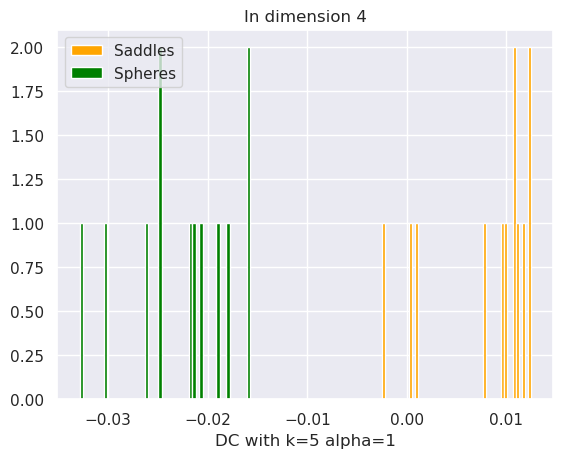

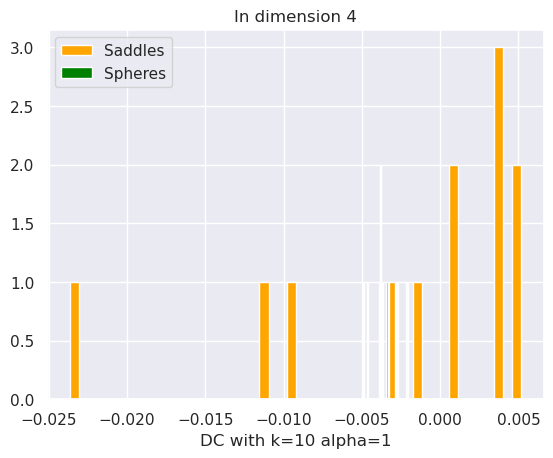

pearson_r  \
ks                     (0.9999999999999997, 4.563495604573848e-167)   
DC with k=5 alpha=1   (-0.9485639824184241, 1.8094052483969595e-12)   
DC with k=10 alpha=1     (-0.11245065509199581, 0.6008705447308613)   

                      sign_score  
ks                      0.693147  
DC with k=5 alpha=1     0.546253  
DC with k=10 alpha=1    0.264041

In [10]:
SS.plot()
SS.table()

In [5]:
SS.DS

<xarray.Dataset>
Dimensions:  (n: 2000, d: 5)
Dimensions without coordinates: n, d
Data variables: (12/24)
    0        (n, d) float64 0.0 0.0 0.0 0.0 0.0 ... -0.4978 0.7781 0.2214 1.016
    1        (n, d) float64 0.1313 0.5424 -0.5861 ... -0.1562 0.3897 -0.6802
    2        (n, d) float64 0.0 0.0 0.0 0.0 ... 0.5584 -0.1221 0.4876 -0.2128
    3        (n, d) float64 -0.6187 0.3675 0.04263 ... -0.528 -0.2709 -0.4979
    4        (n, d) float64 0.0 0.0 0.0 0.0 ... 0.241 -0.08382 -0.3022 -0.05227
    5        (n, d) float64 0.2354 0.4837 -0.3038 ... 0.2629 0.3133 0.8248
    ...       ...
    18       (n, d) float64 0.0 0.0 0.0 0.0 0.0 ... 0.7924 -0.6003 0.1377 0.534
    19       (n, d) float64 0.1078 0.01309 -0.02591 ... 0.1133 0.2396 -0.7287
    20       (n, d) float64 0.0 0.0 0.0 0.0 0.0 ... -0.6971 0.8576 0.7854 -0.348
    21       (n, d) float64 -0.7191 -0.4924 -0.1085 ... 0.1091 -0.0923 0.6176
    22       (n, d) float64 0.0 0.0 0.0 0.0 ... 0.686 0.05145 -0.7174 -0.9819
    23       (n, d) float64 -0.2005 -0.6687 -0.1118 ... -0.2772 0.8787 -0.1262

In [8]:
method_names = SS.DS.data_vars[0].attrs.keys()

In [7]:
method_names = SS.DS.data_vars[0].attrs.keys()
labels = {}
for m in method_names:
    labels[m] = np.array([SS.DS.data_vars[i].attrs[m] for i in range(SS.num_pointclouds)])

KeyError: 'No variable named 24. Variables on the dataset include [0, 1, 2, 3, 4, ..., 19, 20, 21, 22, 23]'

# Dimension 4 - Wasserstein - MIOFlattener

In [13]:
import asyncio
from tqdm import trange
dim = 4
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 25, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
)

async def process_alpha_k(X, alpha, k):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="MIOFlow",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=25, X=X)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for k in [5]:
            tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's:   0%|       | 0/25 [00:00<?, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:   4%| | 1/25 [06:28<2:35:25, 388.56

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  16%|▏| 4/25 [25:57<2:16:16, 389.35

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  20%|▏| 5/25 [32:27<2:09:54, 389.72

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  24%|▏| 6/25 [38:58<2:03:33, 390.18

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  28%|▎| 7/25 [45:26<1:56:49, 389.41

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  32%|▎| 8/25 [51:54<1:50:13, 389.06

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  36%|▎| 9/25 [58:29<1:44:11, 390.70

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  40%|▍| 10/25 [1:05:02<1:37:52, 391

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  44%|▍| 11/25 [1:11:27<1:30:54, 389

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  48%|▍| 12/25 [1:17:56<1:24:20, 389

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  52%|▌| 13/25 [1:24:22<1:17:39, 388

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  56%|▌| 14/25 [1:30:50<1:11:11, 388

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  60%|▌| 15/25 [1:37:22<1:04:53, 389

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  64%|▋| 16/25 [1:43:59<58:43, 391.5

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  68%|▋| 17/25 [1:50:28<52:06, 390.8

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  72%|▋| 18/25 [1:56:55<45:28, 389.7

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  76%|▊| 19/25 [2:03:25<38:58, 389.8

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  80%|▊| 20/25 [2:09:54<32:28, 389.6

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  84%|▊| 21/25 [2:16:28<26:02, 390.7

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  88%|▉| 22/25 [2:22:58<19:31, 390.5

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  92%|▉| 23/25 [2:29:26<12:59, 389.8

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Processing X's:  96%|▉| 24/25 [2:36:07<06:33, 393.1

KeyError: 'No variable named 24. Variables on the dataset include [0, 1, 2, 3, 4, ..., 19, 20, 21, 22, 23]'

SS = 

In [14]:
SS.num_pointclouds -= 1

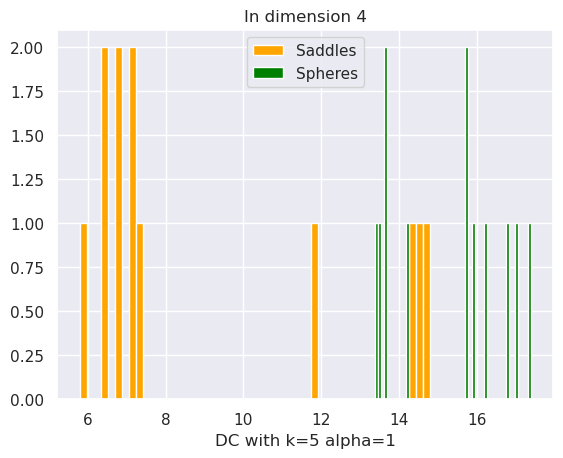

pearson_r  sign_score
ks                   (0.9999999999999997, 4.563495604573848e-167)    0.693147
DC with k=5 alpha=1  (0.7596319886548513, 1.6673671974336737e-05)    0.000000

In [15]:
SS.plot()
SS.table()

# Results

# Conclusion